In [1]:
#data
import pandas as pd
import os
import numpy as np
import json

In [2]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
#statistics
from sklearn import metrics
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import load_boston
# from sklearn.model_selection import timportance_type=split
from sklearn.inspection import permutation_importance

In [4]:
def fdr(df,p):
    
    '''
    Inputs:
    df: dataframe of p-values
    p: p-value column
    
    '''
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)


In [5]:
def ppoints(n, a):
    
    '''numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number'''
    
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

In [6]:
def calculate_ols(df, x, y):
    
    '''
    Inputs:
    df: dataframe of phenotypes
    x: pheno1
    y: pheno2
    '''
    ols = linear_model.LinearRegression()
    df=df[~df[x].isnull()]
    df=df[~df[y].isnull()]
    X=df[x].values.reshape(-1, 1)
    y=df[y].values.reshape(-1, 1)
        
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    results=model.fit()

    return(results.pvalues[1],results.params[1])

In [7]:
def compile_freq(freq_directory, cohorts):
    
    '''
    freq_directory: directory with frequency files
    cohorts: list of cohorts to compiled frequencies
    '''
    
    compiled_freq=pd.DataFrame()

    for x in cohorts:
        print(x)
        f=pd.read_csv(freq_directory+x+".freq.afreq",delimiter="\t")
        f["study"]=x
        compiled_freq=compiled_freq.append(f)
    
    return(compiled_freq)

def extract_freq(compiled_freq, extract, exclude):
    '''
    compiled_freq: dataframe of compiled_frequencies
    extract: list of snps to extract
    exclude: list of snps to exclude
    '''
    
    freq=compiled_freq[compiled_freq["ID"].isin(extract)]
    freq=freq[~freq["ID"].isin(exclude)]
    
    return(freq)

### ICB mapping

In [8]:
df_mapping=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
mp_rna_geno=dict(zip(df_mapping[~df_mapping["tumor RNA id"].isnull()]["tumor RNA id"],df_mapping[~df_mapping["tumor RNA id"].isnull()]["normal WXS id"]))
mp_study=dict(zip(df_mapping['normal WXS id'],df_mapping["study_cancer"]))
mp_sex=dict(zip(df_mapping["normal WXS id"],df_mapping["Gender"]))
mp_age=dict(zip(df_mapping["normal WXS id"],df_mapping["Age"]))

#get phenotype data
pheno=pd.read_csv("/nrnb/users/mpagadal/ARCHIVE/immunotherapy-trials/normal_wxs/phenos/total.pheno.responder.v2.txt",delimiter="\t")
mp_pheno=dict(zip(pheno["FID"],pheno["response_crist_sd"]))

In [9]:
snps=pd.read_csv("../tables/time-germline.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
mp_assoc=dict(zip(snps["snp_noallele"],snps["file"]))

### Extract variants with MAF > 0.05 in discovery cohort

In [10]:
v1_cohorts=["snyder","hugo","riaz","vanallen"]

compiled_freq=compile_freq("../data/icb-response/metal/input/response_crist_sd/",v1_cohorts)
print("{} ICB SNPs available through imputation".format(len(compiled_freq["ID"].unique())))

common_compiled_freq=compiled_freq[compiled_freq["ALT_FREQS"]>0.05] #Trying altered threshold
#common_compiled_freq=compiled_freq[compiled_freq["ALT_FREQS"]>0.25]

print("{} ICB SNPs with MAF > 0.01 available through imputation".format(len(common_compiled_freq["ID"].unique())))

snyder
hugo
riaz
vanallen
39127678 ICB SNPs available through imputation
4489839 ICB SNPs with MAF > 0.01 available through imputation


In [11]:
#compiled_freq

In [12]:
#1084 TIME snps
time_snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/snp-tables/extract-all-time-variants-proxy.txt",header=None)[0].tolist()
exclude=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/snp-tables/exclude-high-mismatch-icb-snps.txt",header=None)[0].tolist()
exclude=exclude+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in exclude]

time_freq=extract_freq(common_compiled_freq,time_snps,exclude)
counts=time_freq["ID"].value_counts().reset_index()
print("{} snps with MAF > 0.05 in all studies".format(len(counts[counts["ID"]>(len(v1_cohorts)-1)])))

#extract variants with MAF > 0.05 in all studies
icb_snps=counts[counts["ID"]>(len(v1_cohorts)-1)]["index"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in counts[counts["ID"]>(len(v1_cohorts)-1)]["index"].tolist()]
icb_snps=pd.DataFrame({"snps":icb_snps})

562 snps with MAF > 0.05 in all studies


In [13]:
#get high imputed snps
info=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-geno-qc/compiled.info",delimiter="\t")
high_impute_info=info[info["Rsq"]>0.3]
high_imputed_snps=high_impute_info["SNP"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in high_impute_info["SNP"].tolist()]

In [14]:
dict_freq=compiled_freq[["ID","ALT_FREQS"]].groupby("ID").mean()
mp_freq=dict(zip(dict_freq.index,dict_freq["ALT_FREQS"]))

### META-ANALYSIS of ICB response in 6 ICB studies

### Get agnostic analysis

(525, 7)


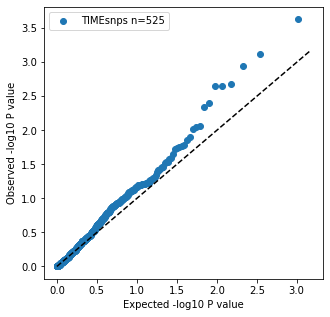

In [15]:
#get metal analysis results
sd_metal=pd.read_csv("../data/icb-response/metal/output/response_crist_sd/v1.effect/METAANALYSIS1.TBL",delimiter="\t")
sd_metal=sd_metal[sd_metal["MarkerName"].isin(icb_snps["snps"].tolist())] #keep snps with MAF > 0.05 in all cohorts
sd_metal=sd_metal[sd_metal["MarkerName"].isin(high_imputed_snps)] #include high confidence snps only
print(sd_metal.shape)
sd_metal=fdr(sd_metal,"P-value")

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

p_values=sd_metal.sort_values(by="P-value")["P-value"].tolist()
plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values),label="TIMEsnps n="+str(len(p_values)))

ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel("Observed -log10 P value")
plt.legend()
plt.savefig("../plots/fig5/icb.qq.pdf")

In [16]:
#plot histogram

In [17]:
sd_metal["snp_noallele"]=sd_metal["MarkerName"].str.rsplit(":",2).str[0]
sd_metal["freq"]=sd_metal["MarkerName"].map(mp_freq)
sd_metal["file"]=sd_metal["snp_noallele"].map(mp_assoc)

In [18]:
#sd_metal.to_csv("/cellar/users/tsears/projects/germline-immune/data/supplemental/Supplemental_Table_8_MAF_0.1.csv",index=None)

### Create burden score with SNPs in other cohort

In [19]:
random_state=10

In [20]:
def make_burden(raw, snps, mp_alleles):
    #get raw ICB genotypes
    raw=pd.read_csv(raw,delim_whitespace=True)
    raw=raw.set_index("FID")
    raw=raw.iloc[:,5:]
    
    snps=pd.DataFrame({"ID":snps})
    snps["A1"]=snps["ID"].map(mp_alleles)
    print("constructing burden from {} snps".format(len(snps)))
    
    burden_snps=[]

    # Iterate through ICB associated snps

    
    for i,row in snps.iterrows():
        
        mp={0:2,1:1,2:0}
        
        snp_all=[x for x in raw.columns if row["ID"] in x]
        
        if len(snp_all) == 0:
            continue
            
        snp=snp_all[0]
        
        min_allele=snp.split("_")[1]
        if min_allele != row["A1"]: #switching genotype if minor alleles are not aligned
            #print("switching genotype {}".format(snp))
            raw[snp]=raw[snp].map(mp)
        
        burden_snps.append(snp)
    
    #make burden score
    raw_burden=raw[burden_snps]
    raw_burden["score"]=raw_burden.sum(axis=1) 
    raw_burden["burden"]=raw_burden["score"]/(len(burden_snps)*2)
    
    return(raw_burden)

### pvalue 0.05

In [21]:
sd_metal_sig=sd_metal[sd_metal["P-value"]<0.05]
sd_metal_sig.sort_values(by=["MarkerName","file"])
snps_sig=pd.merge(snps,sd_metal_sig,left_on="snp_noallele",right_on="snp_noallele")

In [22]:
mp_alleles={}

for i,row in sd_metal_sig.iterrows():
    count=0
    for sign in row["Direction"]:
        if sign == "+":
            count+=1
    if count > 2:
        mp_alleles[row["MarkerName"]]=row["Allele1"].upper()
    else:
        mp_alleles[row["MarkerName"]]=row["Allele2"].upper()   

In [23]:
sig_burden=make_burden("../data/icb-genotypes/all.time.raw",sd_metal_sig["MarkerName"].tolist(),mp_alleles)
sig_burden["study"]=sig_burden.index.map(mp_study)
sig_burden["pheno"]=sig_burden.index.map(mp_pheno)
sig_burden=sig_burden[~sig_burden["pheno"].isnull()]

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
#Map beta values from crist study onto SNPs if applicable
#read in beta_table
beta_table=pd.read_csv("../data/icb-response/prsice-associations/response_crist_sd.prsice.response_crist_sd.glm.logistic.hybrid",delimiter='\t')
#trim beta table to only ADD
beta_table=beta_table[beta_table["TEST"]=="ADD"]
#adjust mapping colname
s=beta_table["ID"].str.rsplit(":",2)
sm = np.array(s.tolist())
sm_chars=sm[:,2]
beta_table["proxy_variant_chars"]=beta_table["ID"]+"_"+sm_chars
#multiply snp_sig beta value on each matching SNP column
for i in beta_table["proxy_variant_chars"]:
    if i in sig_burden:
        sig_burden[i]=sig_burden[i]*float(beta_table.loc[beta_table["proxy_variant_chars"]==i,"OR"])   

In [25]:
sig_burden_LASSO_training=sig_burden[sig_burden["study"].isin(["vanallen","hugo","riaz","snyder"])]
sig_burden_LASSO_testing=sig_burden[sig_burden["study"].isin(["miao","rizvi"])]
sig_burden_LASSO_training_x=sig_burden_LASSO_training.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_training_y=sig_burden_LASSO_training['pheno']
sig_burden_LASSO_testing_x=sig_burden_LASSO_testing.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_testing_y=sig_burden_LASSO_testing['pheno']

0.8428495481127061


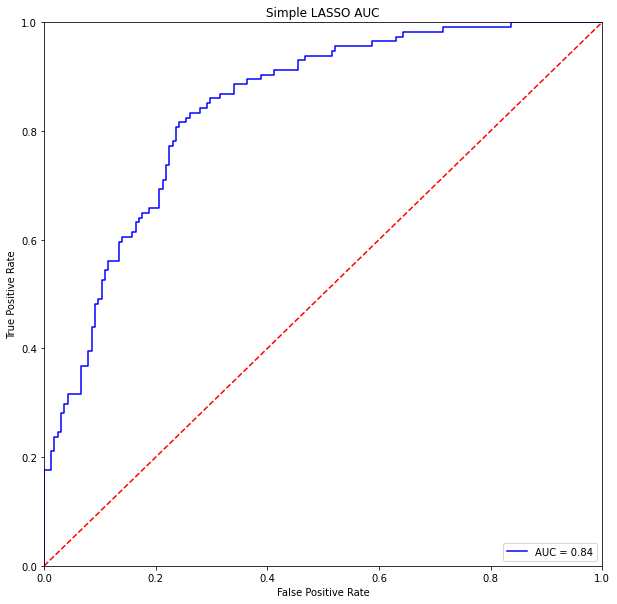

['16:23458272:T:C_C']


In [26]:
# define model
model = Lasso(alpha=0.001,random_state=random_state)
# fit model
model.fit(sig_burden_LASSO_training_x, sig_burden_LASSO_training_y)
p = model.predict(sig_burden_LASSO_training_x)  # test the output by changing values
preds=p

fpr, tpr, threshold = metrics.roc_curve(list(sig_burden_LASSO_training_y), preds,pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(sig_burden_LASSO_training_x.columns.values[model.coef_==0])


In [27]:
sig_burden_dropped=sig_burden.drop(sig_burden_LASSO_training_x.columns.values[model.coef_==0],axis=1)

In [28]:
sig_burden_LASSO_training_dropped=sig_burden_dropped[sig_burden_dropped["study"].isin(["vanallen","hugo","riaz","snyder"])]
sig_burden_LASSO_testing_dropped=sig_burden_dropped[sig_burden_dropped["study"].isin(["miao","rizvi"])]

sig_burden_LASSO_training_x_dropped=sig_burden_LASSO_training_dropped.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_training_y_dropped=sig_burden_LASSO_training_dropped['pheno']

sig_burden_LASSO_testing_x_dropped=sig_burden_LASSO_testing_dropped.drop(['score', 'burden','study','pheno'], axis=1)
sig_burden_LASSO_testing_y_dropped=sig_burden_LASSO_testing_dropped['pheno']

In [29]:
regressor_xgb = xgboost.XGBRFRegressor(n_estimators =500, random_state = random_state,learning_rate=0.1,max_depth=9)
regressor_xgb.fit(sig_burden_LASSO_training_x_dropped, sig_burden_LASSO_training_y_dropped)  

p = regressor_xgb.predict(sig_burden_LASSO_testing_x_dropped)  # test the output by changing values
p_disc=regressor_xgb.predict(sig_burden_LASSO_training_x_dropped)

sig_burden_LASSO_testing_dropped["LASSO_burden"]=p
sig_burden_LASSO_training_dropped["LASSO_burden"]=p_disc

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

<Figure size 360x360 with 0 Axes>

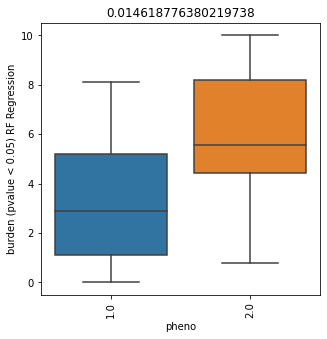

In [30]:
fig = plt.figure(figsize=(5,5))
validation=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="rizvi"]

validation_plot=validation
minmax_scale = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 10))
x = validation_plot["LASSO_burden"].values.reshape(-1, 1)
validation_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

sns.boxplot(x="pheno",y="LASSO_scaled",data=validation_plot)

cat1 = validation[validation["pheno"]==1]
cat2 = validation[validation["pheno"]==2]
rizvi_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/rizvi_LASSO_PRS_scaled.pdf")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

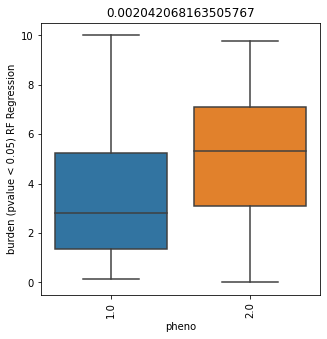

In [31]:
validation=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="miao"]
validation_plot=validation
minmax_scale = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 10))
x = validation_plot["LASSO_burden"].values.reshape(-1, 1)
validation_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))
sns.boxplot(x="pheno",y="LASSO_scaled",data=validation_plot)
cat1 = validation[validation["pheno"]==1]
cat2 = validation[validation["pheno"]==2]
miao_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()
plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/miao_LASSO_PRS_scaled.pdf")

In [32]:
features = sig_burden_LASSO_testing_x_dropped.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("../tables/time-germline.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snps","rsid"]]

mapping_table["ID2"]=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in mapping_table["ID"].tolist()]

compiled_icb_rsid=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snps")
compiled_icb_rsid2=pd.merge(mapping_table,rsid_table,left_on="ID2",right_on="snps")

compiled_icb_rsid_plot=pd.concat([compiled_icb_rsid,compiled_icb_rsid2],axis=0)
compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot_snps=compiled_icb_rsid_plot["snps"]
compiled_icb_rsid_plot_snps=pd.DataFrame(compiled_icb_rsid_plot_snps.tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in compiled_icb_rsid_plot_snps.tolist()])
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


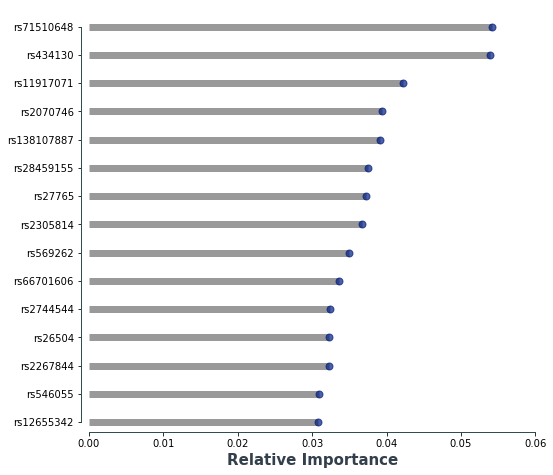

In [33]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.06)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig6/feature_importance_V2.pdf",bbox_inches = "tight")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


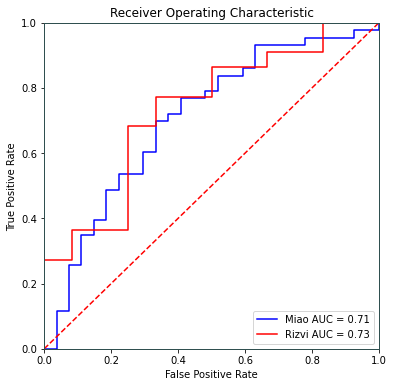

In [34]:
validation_miao=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="miao"]
validation_rizvi=sig_burden_LASSO_testing_dropped[sig_burden_LASSO_testing_dropped["study"]=="rizvi"]
preds=p

fpr, tpr, threshold = metrics.roc_curve(validation_miao["pheno"],validation_miao["LASSO_burden"],pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

fpr1, tpr1, threshold1 = metrics.roc_curve(validation_rizvi["pheno"],validation_rizvi["LASSO_burden"],pos_label=2)
roc_auc1 = metrics.auc(fpr1, tpr1)

# method I: plt
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Miao AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'b', label = 'Rizvi AUC = %0.2f' % roc_auc1,color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("../plots/fig5/validation_auc_plot.pdf")
plt.show()

### Take random TIME snps

In [35]:
sd_time_metal_sample=sd_metal[~sd_metal["file"].isin(sd_metal_sig["file"].tolist())]
raw=pd.read_csv("../data/icb-genotypes/all.time.raw",delim_whitespace=True,nrows=0)
snps=[x.split("_")[0] for x in raw.columns[6:]]
snps=snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in snps]
sd_time_metal_sample=sd_time_metal_sample[sd_time_metal_sample["MarkerName"].isin(snps)]

In [36]:
len(sd_time_metal_sample["MarkerName"].unique())

206

In [37]:
#Generate model and run it over 100 times
disc_mean_list=[]
miao_mean_list=[]
rizvi_mean_list=[]

for num in range(100):
    
    if num % 10 ==0:
        print("{} iterations done".format(num))
    
    #get random subset of sd_time_metal_sample
    sd_time_metal_sample_subset=sd_time_metal_sample.sample(n=sd_metal_sig.shape[0], random_state=num)
    
    #get mp_alleles object
    mp_alleles={}

    for i,row in sd_time_metal_sample_subset.iterrows():
        count=0
        for sign in row["Direction"]:
            if sign == "+":
                count+=1
        if count > 2:
            mp_alleles[row["MarkerName"]]=row["Allele1"].upper()
        else:
            mp_alleles[row["MarkerName"]]=row["Allele2"].upper()
        
    #make burden of subset in correct format
    sig_burden_sample=make_burden("/cellar/users/mpagadal/projects/germline-immune/data/icb-genotypes/all.time.raw",sd_time_metal_sample_subset["MarkerName"].tolist(),mp_alleles)
    sig_burden_sample["study"]=sig_burden_sample.index.map(mp_study)
    sig_burden_sample["pheno"]=sig_burden_sample.index.map(mp_pheno)
    sig_burden_sample=sig_burden_sample[~sig_burden_sample["pheno"].isnull()]
    
    
    #Generate dataset split and run model
    sig_burden_LASSO_training=sig_burden_sample[sig_burden_sample["study"].isin(["vanallen","hugo","riaz","snyder"])]
    sig_burden_LASSO_testing=sig_burden_sample[sig_burden_sample["study"].isin(["miao","rizvi"])]

    sig_burden_LASSO_training_x=sig_burden_LASSO_training.drop(['score', 'burden','study','pheno'], axis=1)
    sig_burden_LASSO_training_y=sig_burden_LASSO_training['pheno']

    sig_burden_LASSO_testing_x=sig_burden_LASSO_testing.drop(['score', 'burden','study','pheno'], axis=1)
    sig_burden_LASSO_testing_y=sig_burden_LASSO_testing['pheno']


    regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 500, random_state = 10,learning_rate=0.1,max_depth=9) 
    regressor_xgb.fit(sig_burden_LASSO_training_x, sig_burden_LASSO_training_y)   

    p = regressor_xgb.predict(sig_burden_LASSO_testing_x)  # test the output by changing values
    p_disc=regressor_xgb.predict(sig_burden_LASSO_training_x)

    sig_burden_LASSO_testing["LASSO_burden"]=p
    sig_burden_LASSO_training["LASSO_burden"]=p_disc


    miao1 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="miao",sig_burden_LASSO_testing["pheno"]==1)]
    miao2 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="miao",sig_burden_LASSO_testing["pheno"]==2)]
    miao_mean_list.append(miao2.mean()-miao1.mean())
    
    rizvi1 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="rizvi",sig_burden_LASSO_testing["pheno"]==1)]
    rizvi2 = p[np.logical_and(sig_burden_LASSO_testing["study"]=="rizvi",sig_burden_LASSO_testing["pheno"]==2)]
    rizvi_mean_list.append(rizvi2.mean()-rizvi1.mean())
    
    disc1 = p_disc[sig_burden_LASSO_training["pheno"]==1]
    disc2 = p_disc[sig_burden_LASSO_training["pheno"]==2]
    disc_mean_list.append(disc2.mean()-disc1.mean())

0 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

10 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

20 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

30 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

40 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

50 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

60 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

70 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

80 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

90 iterations done
constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

constructing burden from 32 snps


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

0.0


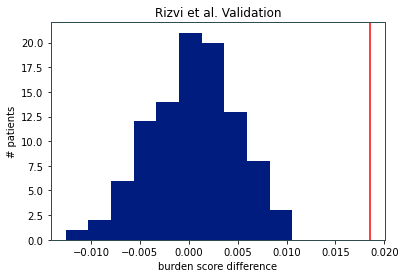

In [38]:
plt.hist(rizvi_mean_list)
truth=rizvi_score
plt.axvline(truth,color="red")
plt.xlabel("burden score difference")
plt.ylabel("# patients")
plt.title("Rizvi et al. Validation")
print(len([x for x in rizvi_mean_list if x > truth])/len(rizvi_mean_list))
plt.savefig("../plots/fig5/GENE_method_rizvi.bootstrapping.pdf")

0.0


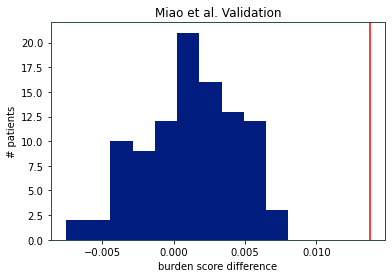

In [39]:
plt.hist(miao_mean_list)
truth=miao_score
plt.axvline(truth,color="red")
plt.xlabel("burden score difference")
plt.ylabel("# patients")
plt.title("Miao et al. Validation")
print(len([x for x in miao_mean_list if x > truth])/len(miao_mean_list))
plt.savefig("../plots/fig5/GENE_method_miao.bootstrapping.pdf")

### PCA plotting

In [40]:
sd_metal_sig_dropped=sd_metal_sig[sd_metal_sig["MarkerName"]!="16:23458272:T:C"] #snp dropped from lasso model
sd_metal_sig_dropped.shape

(31, 12)

In [41]:
#get mapping file
mapping=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
print(len(mapping["normal WXS id"].unique()))
mapping=mapping[~(mapping["tumor RNA id"].isnull())]

742


In [42]:
pca=pd.read_csv("../data/icb-geno-qc/pca/icb-time/pcs.txt",delimiter="\t")
mp_study=mp_study=dict(zip(mapping["normal WXS id"],mapping["study"]))
pca["study"]=pca["IID"].map(mp_study)

In [43]:
pca["study"].value_counts()

liu         115
riaz         52
vanallen     40
miao         33
hugo         27
Name: study, dtype: int64

In [44]:
pca=pca[pca["study"].isin(["hugo","vanallen","miao","riaz","rizvi","snyder"])]

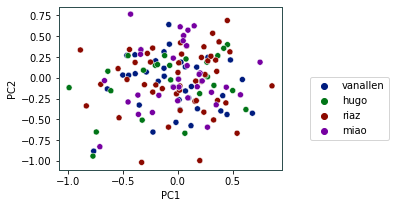

In [45]:
fig = plt.figure(figsize=(4,3))
sns.scatterplot(x="PC1",y="PC2",hue="study",data=pca)
plt.legend(bbox_to_anchor=(1.5,.6))
plt.savefig("../plots/fig5/icb.geno.pca.pdf")

In [46]:
loadings=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-geno-qc/pca/icb-time/loadings.txt",delimiter="\t")

In [47]:
icb_snps=[x for x in loadings.sort_values(by="V1")["SNP"].tolist() if "3:" in x]

### Check effects of variants

In [48]:
len(sd_metal_sig_dropped)

31

In [49]:
sd_metal_sig_dropped=sd_metal_sig.drop(sd_metal_sig[sd_metal_sig["MarkerName"]=="16:23458272:T:C"].index) #this is the snp that has been dropped in the final model
extract=sd_metal_sig_dropped["MarkerName"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in sd_metal_sig_dropped["MarkerName"].tolist()]

assoc_dir="../data/icb-response/metal/input/response_crist_sd/"
compiled_icb=pd.DataFrame()

for file in [x for x in os.listdir(assoc_dir) if "add" in x]:
    print(file)
    icb=pd.read_csv(assoc_dir+file,delimiter="\t")
    icb=icb[icb["ID"].isin(extract)]
    icb=fdr(df=icb,p="P")
    icb["file"]=file
    compiled_icb=compiled_icb.append(icb)

vanallen.assoc.logistic.add
crist_hnscc.assoc.logistic.add
hugo.assoc.logistic.add
liu.assoc.logistic.add
riaz.assoc.logistic.add
crist_melanoma.assoc.logistic.add
snyder.assoc.logistic.add
rizvi.assoc.logistic.add
miao.assoc.logistic.add


In [50]:
compiled_icb["log(OR)"]=np.log10(compiled_icb["OR"])
compiled_icb["file"]=compiled_icb["file"].str.split(".").str[0]
compiled_icb=compiled_icb[compiled_icb["file"].isin(["vanallen","snyder","rizvi","riaz","hugo","miao"])]
compiled_icb["BP"]=compiled_icb["ID"].str.split(":").str[1].astype(int)
compiled_icb=compiled_icb.sort_values(by=["#CHROM","BP","file"])

In [51]:
rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table["snps2"]=rsid_table["snps"].str.rsplit(":",2).str[0]+":"+rsid_table["snps"].str.split(":").str[3]+":"+rsid_table["snps"].str.split(":").str[2]
mp_rsid=dict(zip(rsid_table["snps"],rsid_table["rsid"]))
mp_rsid2=dict(zip(rsid_table["snps2"],rsid_table["rsid"]))
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res
mp_rsid=Merge(mp_rsid,mp_rsid2)

In [52]:
compiled_icb["rsid"]=compiled_icb["ID"].map(mp_rsid)

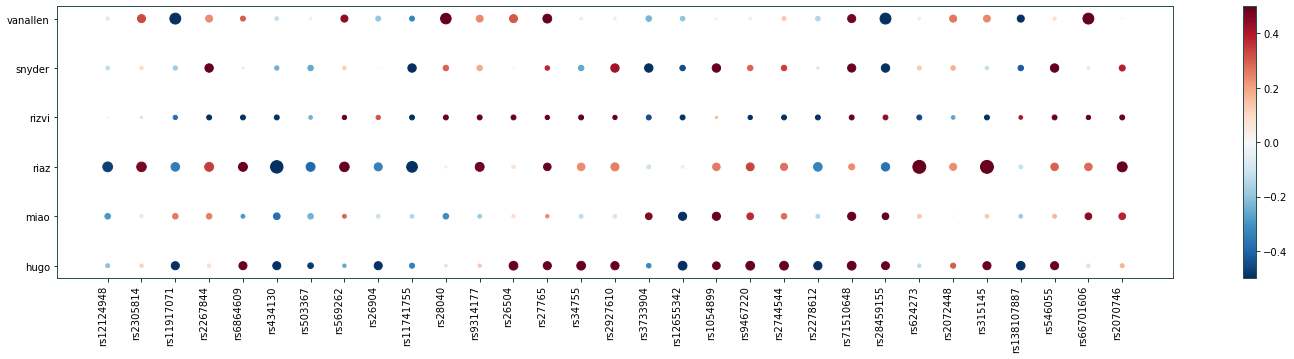

In [53]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 100
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    

heatmap(
    x=compiled_icb['rsid'],
    y=compiled_icb['file'],
    size=compiled_icb['-log10(fdr)'],
    color=compiled_icb['log(OR)'],
)

plt.savefig("../plots/fig5/study.icb.clustermap.pdf")

### Check MAF of variants

In [54]:
v1_cohorts=["snyder","hugo","riaz","vanallen","rizvi","miao"]
compiled_freq=compile_freq("../data/icb-response/metal/input/response_crist_sd/",v1_cohorts)
print("{} ICB SNPs available through imputation".format(len(compiled_freq["ID"].unique())))

snyder


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
compiled_icb_freq=compiled_freq[compiled_freq["ID"].isin(compiled_icb["ID"].unique().tolist())]
compiled_icb_freq=compiled_icb_freq[compiled_icb_freq.ID.isin(sd_metal_sig.sort_values(by="MarkerName")["MarkerName"].tolist())]
df_freq=pd.merge(compiled_icb_freq[["ID","ALT_FREQS"]].groupby("ID").mean(),compiled_icb_freq[["ID","ALT_FREQS"]].groupby("ID").std(),right_index=True,left_index=True)
df_freq.columns=["mean","std"]
df_freq["chr"]=df_freq.index.str.split(":").str[0]
df_freq["chr"]=df_freq["chr"].astype(int)
df_freq=df_freq.sort_values(by="chr")

In [ ]:
df_freq["rsid"]=df_freq.index.map(mp_rsid)

In [ ]:
df_freq["bp"]=df_freq.index.str.split(":").str[1]
df_freq["bp"]=df_freq["bp"].astype(int)

In [ ]:
df_freq=df_freq.sort_values(by=["chr","bp"])

In [ ]:
fig = plt.figure(figsize=(25,1))
plt.errorbar(x=df_freq["rsid"].tolist(),y=df_freq["mean"].tolist(),yerr=df_freq["std"].tolist(),fmt="o",color="gray")
plt.xticks(rotation=90)
plt.savefig("../plots/fig5/maf.error.pdf")

### Check variance explained

In [ ]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [ ]:
with open('/cellar/controlled/dbgap-genetic/ICB/rna/TPMs/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
tpm=pd.DataFrame.from_dict(icb_tpm)

### RNA

In [ ]:
#analyze TPM rna
rna=tpm.copy()
rna+=1
rna=np.log2(rna)

In [ ]:
rna.index=rna.index.str.split(".").str[0]
rna["gene name"]=rna.index.map(ensembl)
rna=rna[~(rna["gene name"].isnull())]
rna.index=rna["gene name"]
del rna["gene name"]
rna=rna.T
rna.index=rna.index.str.split(".sra").str[0]
rna=rna.reset_index()
rna=rna.rename(columns={"index":"FID"})

In [ ]:
mp_study=dict(zip(mapping["tumor RNA id"],mapping["study"]))
mp_time=dict(zip(mapping["tumor RNA id"],mapping["Biopsy Time"]))
mp_response=dict(zip(mapping["normal WXS id"],mapping["Response"]))
mp_rna2geno=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

mp_tmr2geno={}
for i,row in mapping.iterrows():
    for x in row["tumor WXS id"].split(", "):
        mp_tmr2geno[x]=row["normal WXS id"]

In [ ]:
rna["study"]=rna["FID"].map(mp_study)
rna["time"]=rna["FID"].map(mp_time)

rna["FID"]=rna["FID"].map(mp_rna2geno)
rna_filt=rna[~(rna["FID"].isnull())]

rna_filt["response"]=rna_filt["FID"].map(mp_response)

dict_response={"Progressive Disease":"PD","Partial Response":"PR","Complete Response":"CR"}
rna_filt=rna_filt.replace({"response": dict_response})
rna_filt_pre=rna_filt[~rna_filt["time"].isin(["On","on-treatment"])]

In [ ]:
ic_exp=rna_filt_pre[["FID","PDCD1","CD274","CTLA4"]]

### TMB

In [ ]:
tmb=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/tmb/mutect.filtered.muts.tsv",delimiter="\t")
tmb=tmb[["tumor_id"]].groupby(["tumor_id"]).size().reset_index()
tmb.columns=["tumor_id","TMB"]

In [ ]:
tmb["FID"]=tmb["tumor_id"].map(mp_tmr2geno)

In [ ]:
tmb=tmb[~tmb["FID"].isnull()]

In [ ]:
tmb=tmb[["FID","TMB"]].groupby(["FID"]).mean().reset_index()

In [ ]:
print(len(tmb))

### Get germline PRS

In [ ]:
compiled_prs1=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_testing.csv")  #read in new SNP results
compiled_prs2=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/sig_burden_LASSO_training.csv")  #read in new SNP results
compiled_prs=pd.concat([compiled_prs1,compiled_prs2])

In [ ]:
compiled_prs=compiled_prs[["FID","LASSO_burden","pheno","study"]]
compiled_prs.shape

### Get covariate

In [ ]:
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/ICB/covar/total.cov.age.sex.study.v2.txt",delimiter="\t")

### Combine

In [ ]:
markers=pd.merge(ic_exp,tmb[["FID","TMB"]],on="FID",how="left")
markers=pd.merge(markers,compiled_prs,on="FID",how="outer")
markers=pd.merge(markers,cov,on=["FID"])
markers=markers[~markers["study"].isnull()]

In [ ]:
markers["response"]=markers["pheno"].map({2:1,1:0})

In [ ]:
markers_miao_TMB=markers[markers["study"]=="miao"].dropna()
markers_miao=markers[markers["study"]=="miao"]
markers_miao_TMB.shape

### run pseudo_R2 scripts

In [ ]:
results=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/r2.results.csv")
results=results[results["Unnamed: 0"].str.contains("McFadden")]
results=results[~results["Unnamed: 0"].str.contains("Adj")]
results=results.pivot(index="study",columns="model",values="r2").fillna(0)
results=results[results.index.isin(["miao"])]
results=results.reset_index()
results=pd.melt(results,id_vars=["study"],value_vars=["TMB","TMB/PD1/PDL1/CTLA4","TMB/PD1/PDL1/CTLA4+germline","germline PRS only"])
results=results.reindex([2,3,1,0])

In [ ]:
fig = plt.figure(figsize =(5, 7))
plt.rcParams.update({'font.size': 16})
plt.autolayout : True
# Horizontal Bar Plot
plt.barh(results["model"], results["value"],color=["tab:blue","coral","tab:green","firebrick"])
plt.xlabel("Variance Explained")
# Show Plot
plt.title("Miao variance explained")
plt.savefig("../plots/fig5/var.explained.pdf",bbox_inches = "tight")
plt.show()